# Gaussian generative models for handwritten digit classification

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

from urllib.request import urlretrieve

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [4]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

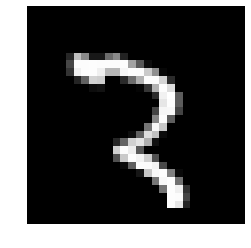

In [5]:
displaychar(train_data[500])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [6]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

In [8]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((48000, 784), (12000, 784), (48000,), (12000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the IRIS example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a hyper-parameter, and by setting it appropriately, we can improve the performance of the model.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [30]:
def fit_generative_model(x,y, c=1):
    ### UPDATE CODE HERE ###
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    for label in range(0,k):
        indices = (y == label)
        class_x = x[indices] # class values
        
        ### START CODE HERE ###
        mu[label] = class_x.mean(axis=0)
        ### Update Code for regularization (smoothing)
        sigma[label] = np.cov(class_x.T) + np.identity(d)*c
        pi[label] = class_x.shape[0] / x.shape[0]  # the prior        
        ### END CODE HERE ###
    
    return mu, sigma, pi


Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

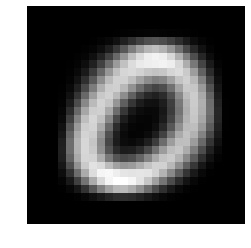

In [31]:
mu, sigma, pi = fit_generative_model(X_train, Y_train)
displaychar(mu[0])
#displaychar(mu[1])
#displaychar(mu[2])

## 3. Make predictions on validate data

Now let's see how many errors your model makes on the validate set.

In [32]:
def logpdf(x, mu, var):
#     var_inv = np.linalg.inv(var) if var.shape[0]>1 else var
#     exp = np.exp(-1.0/2.0 * (x - mu).T *var_inv * (x-mu) )
#     base = np.sqrt(2.0*np.pi* var.size)
#     return  exp / base
    print(dict(x=x.shape,mu=mu.shape,var=var.shape))

    return multivariate_normal.logpdf(x, mu, var)
            

In [33]:
def predict(mu, var, pi, testx, features=None, k=3):
    n_test = testx.shape[0] # Number of test points
    score = np.zeros((n_test, k)) # [test, label]

    for i in range(0, n_test):
        for label in range(0, k):
            # Implement the formula for normal pdf. 

            x_ = testx[i, features]
            mu_ = mu[label, features]
            var_ = var[label, features, features]
            
            p = logpdf(x_, mu_, var_)
            
            score[i, label] = np.mean( pi[label] * p )
    
    predictions = np.argmax(score, axis=1) #think about using np.argmax on score[]
    return predictions

In [34]:
# Compute log Pr(label|image) for each [val image,label] pair.

# Now test the performance of a predictor based on a subset of features
def test_model(mu, sigma, pi, features=None, testx=X_val, testy=Y_val):
    nt = len(testy)
    k = 10
    
    ### predict function, see above cell
    predictions = predict(mu, sigma, pi, testx, features=None, k=k)
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    print ("Your model makes " + str(errors) + " errors out of 12000")
    print("Accuracy = " + str((12000-errors)/12000*100))
    
    return errors/12000


test_model(mu, sigma, pi, testx=X_val, testy=Y_val)

{'x': (1, 784), 'mu': (1, 784), 'var': (1, 1, 784, 784)}


ValueError: Array 'mean' must be a vector of length 784.

## 4. Make predictions on test data

In [37]:
# Compute log Pr(label|image) for each [val image,label] pair.
test_model(mu, sigma, pi, testx=testx, testy=testy)

NameError: name 'testx' is not defined

## 4. Quick exercises

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the validation set?

<font color="magenta">Exercise 4:</font> How many errors did your model make on the test set?

<font color="magenta">Optional</font>: 
1. We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?
2. Try applying multivariate Gaussian classifier on other datasets.